In [16]:
# 02_panel_FE.ipynb
# Author: Hayden Hedman
# Purpose: Estimate treatment effects using fixed effects panel regression
# Simulated data: Staggered diabetes medication intervention

In [17]:
# Load libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("../data/simulated_diabetes_patient_data.csv")
df.head()


,patient_id,month,age,sex,comorb_idx,hypertension,copd,ckd,depression,obesity,treat,baseline_a1c,a1c,hosp,start_month,treated_group,post_treatment,time_since_tx,cohort_month
0,1,0,79,0,0,0,0,0,0,1,0,7.986916,7.236642,0,28,1,0,-28,0
1,1,1,79,0,0,0,0,0,0,1,0,7.986916,8.655890,0,28,1,0,-27,1
2,1,2,79,0,0,0,0,0,0,1,0,7.986916,8.268417,0,28,1,0,-26,2
3,1,3,79,0,0,0,0,0,0,1,0,7.986916,7.281925,0,28,1,0,-25,3
4,1,4,79,0,0,0,0,0,0,1,0,7.986916,8.510633,0,28,1,0,-24,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084032 entries, 0 to 1084031
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   patient_id      1084032 non-null  int64  
 1   month           1084032 non-null  int64  
 2   age             1084032 non-null  int64  
 3   sex             1084032 non-null  int64  
 4   comorb_idx      1084032 non-null  int64  
 5   hypertension    1084032 non-null  int64  
 6   copd            1084032 non-null  int64  
 7   ckd             1084032 non-null  int64  
 8   depression      1084032 non-null  int64  
 9   obesity         1084032 non-null  int64  
 10  treat           1084032 non-null  int64  
 11  baseline_a1c    1084032 non-null  float64
 12  a1c             1084032 non-null  float64
 13  hosp            1084032 non-null  int64  
 14  start_month     1084032 non-null  int64  
 15  treated_group   1084032 non-null  int64  
 16  post_treatment  1084032 non-null  in

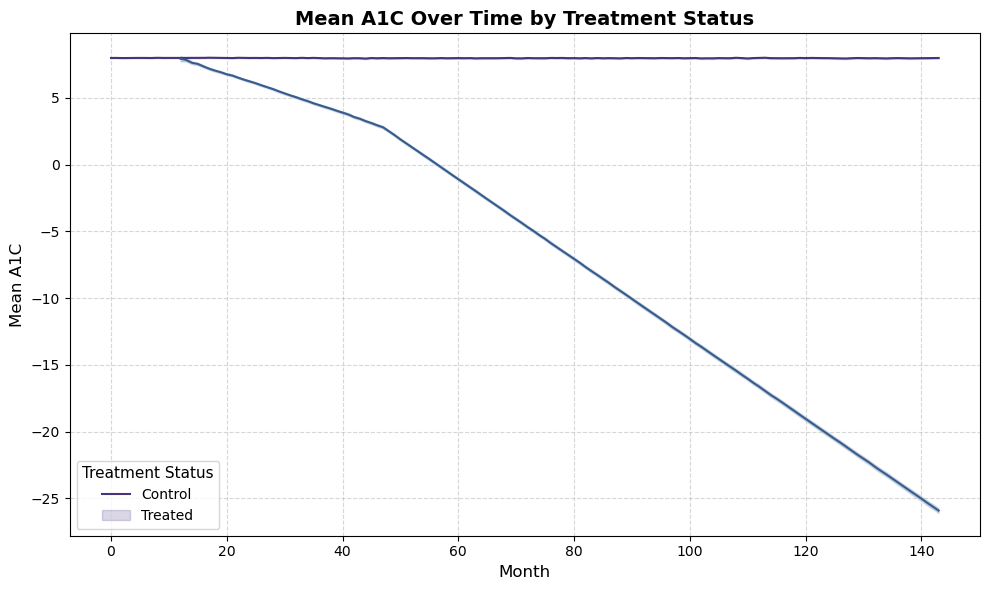

In [18]:
# quick review of data structure
df.info()

# Ensure seaborn uses the viridis palette
sns.set_palette("viridis")

# Plot mean A1C over time by treatment
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="month", y="a1c", hue="treat")

# Styling
plt.title("Mean A1C Over Time by Treatment Status", fontsize=14, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Mean A1C", fontsize=12)
plt.legend(title="Treatment Status", labels=["Control", "Treated"], title_fontsize=11, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
#Create FE-ready Variables
# Center or bucket age (optional)
df["age_grp"] = pd.cut(df["age"], bins=[0, 60, 70, 80, 100], labels=["<60", "60–70", "70–80", "80+"])

# Fixed effects vars
df["post_treatment"] = (df["month"] >= df["start_month"]) & (df["start_month"] < 999)
df["treated_group"] = df["start_month"] < 999
df["cohort_month"] = df["start_month"].replace(999, np.nan)  # cohort FE

# Drop early months if needed
# df = df[df["month"] >= 6]


In [ ]:
# DID-style: treat*time with patient and time fixed effects
model_did = smf.ols(
    "a1c ~ post_treatment + C(month) + C(patient_id)",
    data=df
).fit()

print(model_did.summary())


In [ ]:
# Convert patient_id to categorical for fixed effects
df["patient_id"] = df["patient_id"].astype("category")

# Fit panel regression
model = smf.ols("a1c ~ treat + month + C(patient_id)", data=df).fit()


In [ ]:
# Summary stats by treatment group
df.groupby("treat")[["a1c", "age", "comorb_idx"]].mean()


In [ ]:
# Set Seaborn theme for professional look
sns.set_theme(style="whitegrid")

# Create figure and axis
plt.figure(figsize=(8, 5))

# Plot the lineplot with 95% CI
sns.lineplot(
    data=df,
    x="month",
    y="a1c",
    hue="treat",
    estimator="mean",
    errorbar=('ci', 95),
    palette="viridis",
    linewidth=2.5
)

# Title and labels
plt.title("Average A1c Over Time by Treatment Group", fontsize=14, weight='bold')
plt.suptitle("Simulated patient data | Treatment effect begins at Month 6", fontsize=10, y=0.93)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Hemoglobin A1c (%)", fontsize=12)

# Legend tweaks
plt.legend(title="Treatment", title_fontsize=10, fontsize=9, loc="upper right")

# Tight layout and high DPI export-ready format
plt.tight_layout()
plt.savefig("figures/a1c_by_treatment.png", dpi=300)
plt.show()


In [ ]:
# Extract and display only top rows of coefficients table
coeff_table = fe_model.summary2().tables[1]
display(coeff_table.loc[["Intercept", "post_treatment"]])



In [ ]:
# explore distribution differences
plt.figure(figsize=(6, 4))
sns.set(style="whitegrid", font_scale=1.2)

sns.boxplot(
    data=df,
    x="treat",
    y="a1c",
    hue="treat",            # assign x variable to hue
    palette="viridis",
    width=0.5,
    fliersize=2,
    legend=False            # disable duplicate legend
)


# Custom axis labels
plt.xlabel("Treatment Group", labelpad=10)
plt.ylabel("HbA1c Level", labelpad=10)
plt.title("Distribution of HbA1c by Treatment", pad=15)

# Tidy up layout
plt.xticks([0, 1], ["Control", "Treated"])
plt.tight_layout()
plt.show()


In [ ]:
# Save cleaned long-format panel data for next notebook
# Define output path (relative to notebook location)
output_path = "../data/02_panel_FE_cleaned.csv"

# Save cleaned panel data
df.to_csv(output_path, index=False)
print(f"confirmed: panel data saved to {output_path}")


In [21]:
print(df.columns.tolist())


['patient_id', 'month', 'age', 'sex', 'comorb_idx', 'hypertension', 'copd', 'ckd', 'depression', 'obesity', 'treat', 'baseline_a1c', 'a1c', 'hosp', 'start_month', 'treated_group', 'post_treatment', 'time_since_tx', 'cohort_month', 'age_grp']
